In this notebook, we're gonna implement DecisionTreeRegressor on the Medical Cost personal Dataset.

Link: https://www.kaggle.com/datasets/mirichoi0218/insurance

In [92]:
# importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 5)

## Decision Tree Regression

### Preprocessing & EDA

In [93]:
# loading the dataset
df = pd.read_csv('/content/insurance.csv')
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


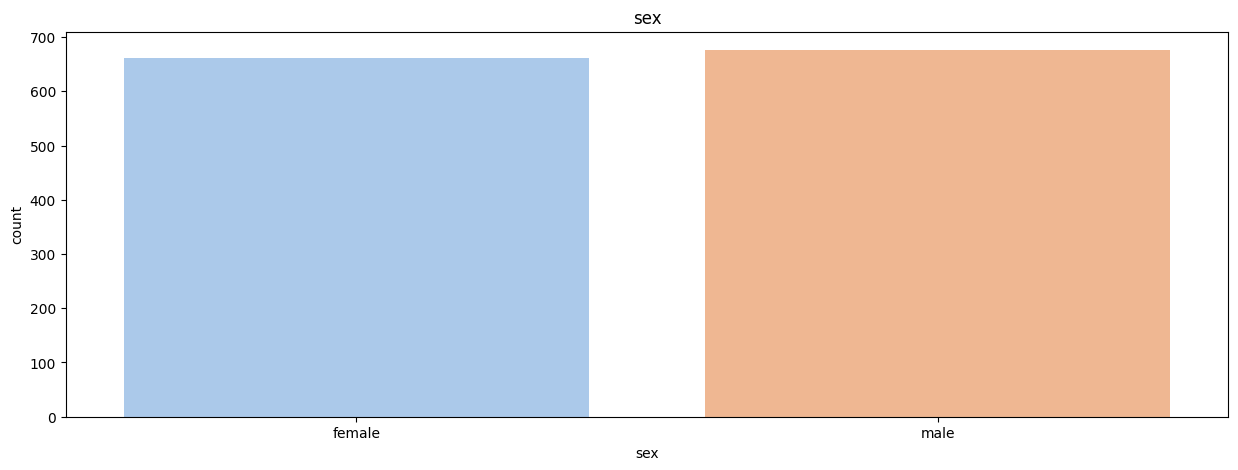

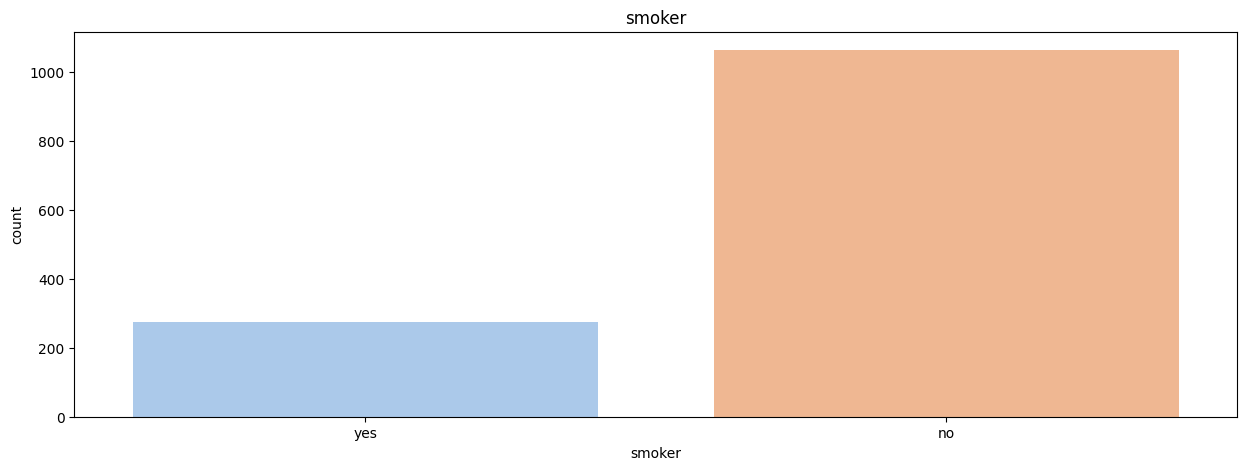

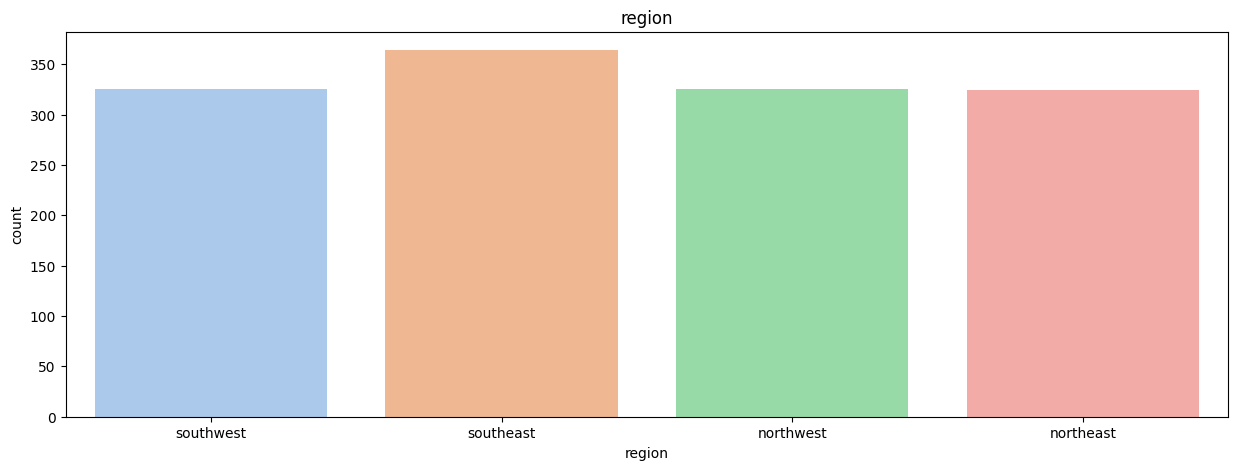

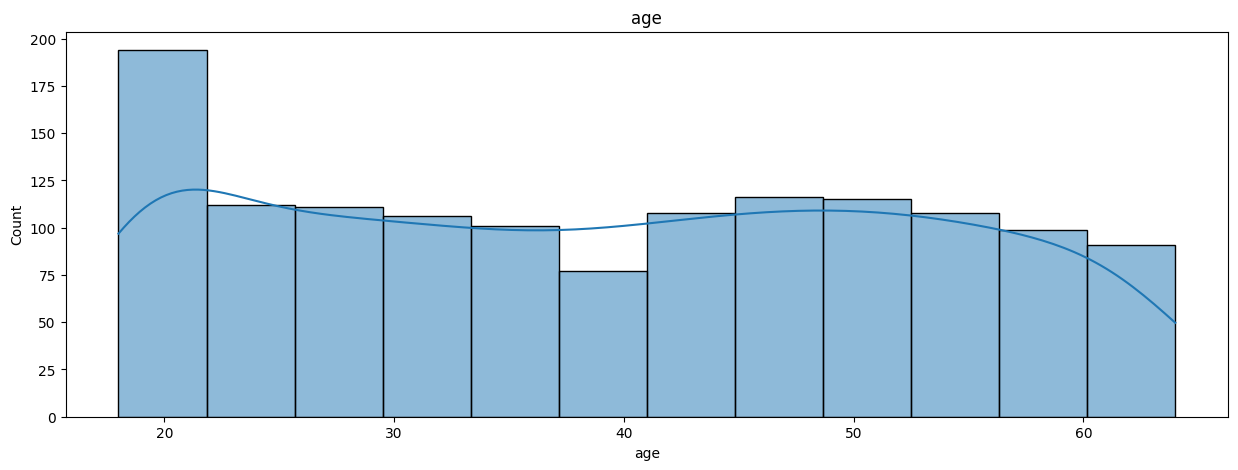

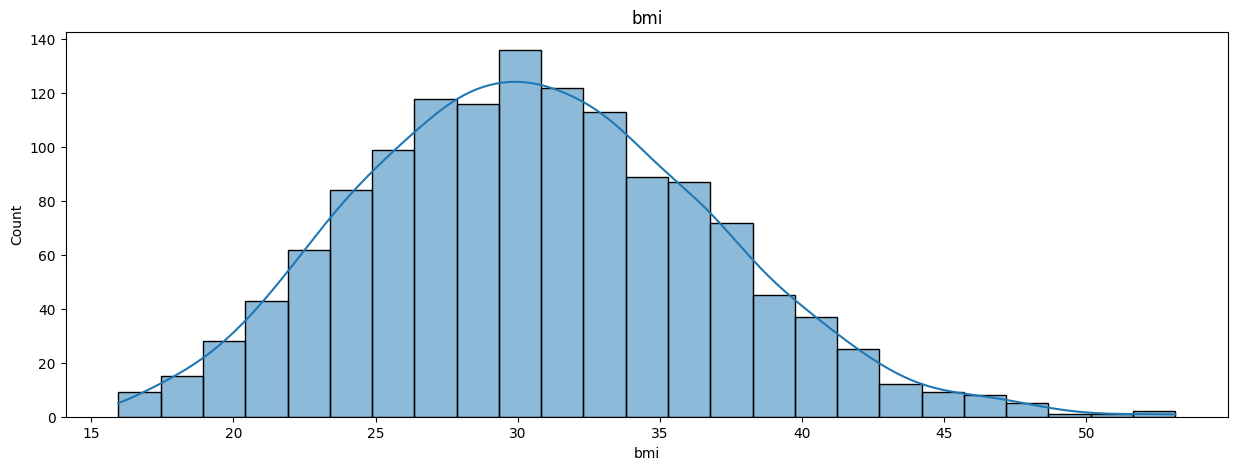

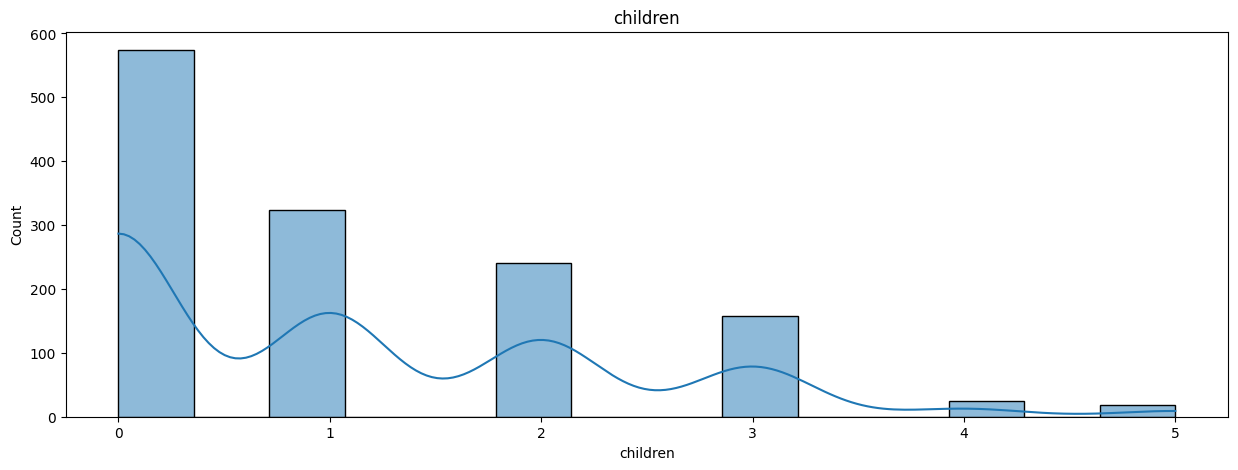

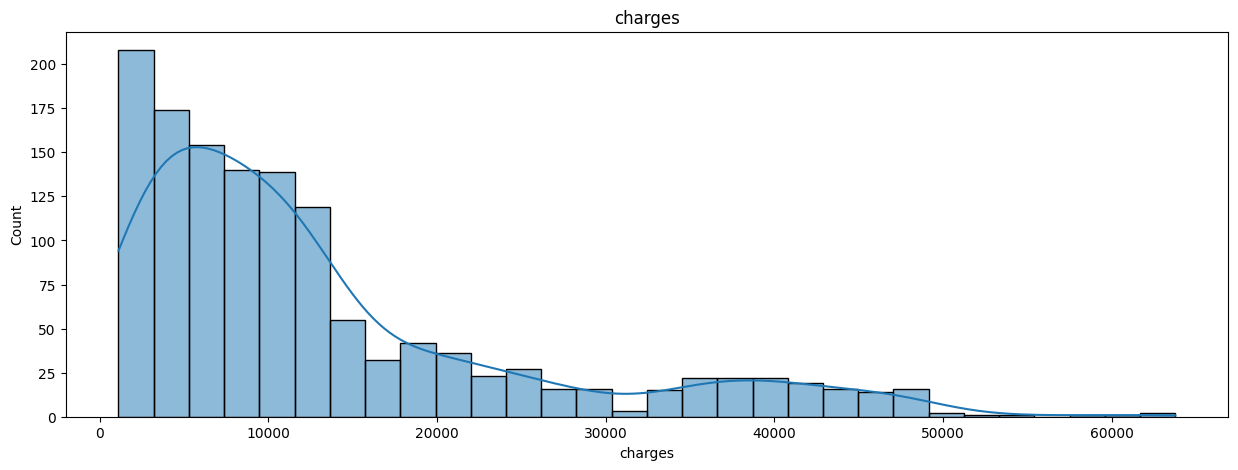

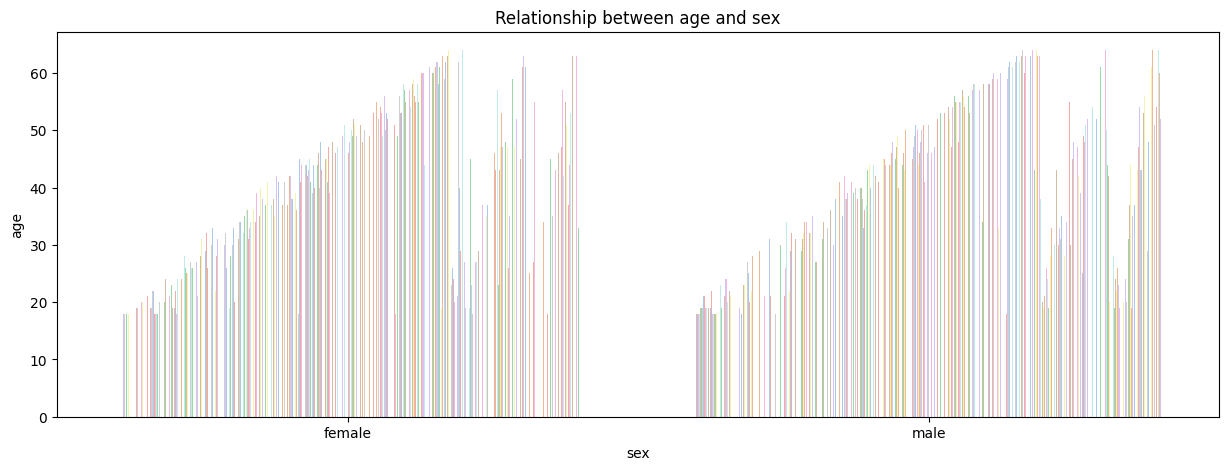

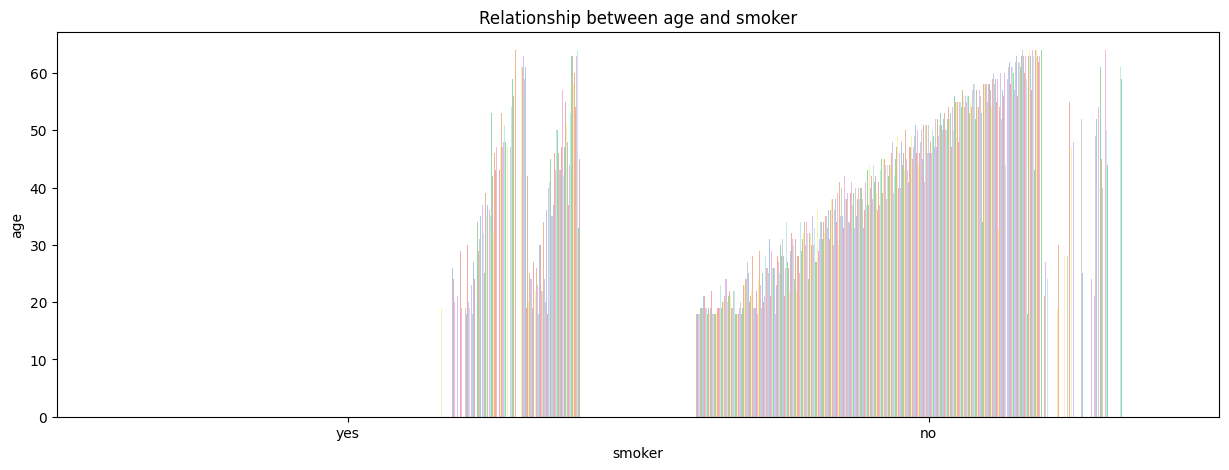

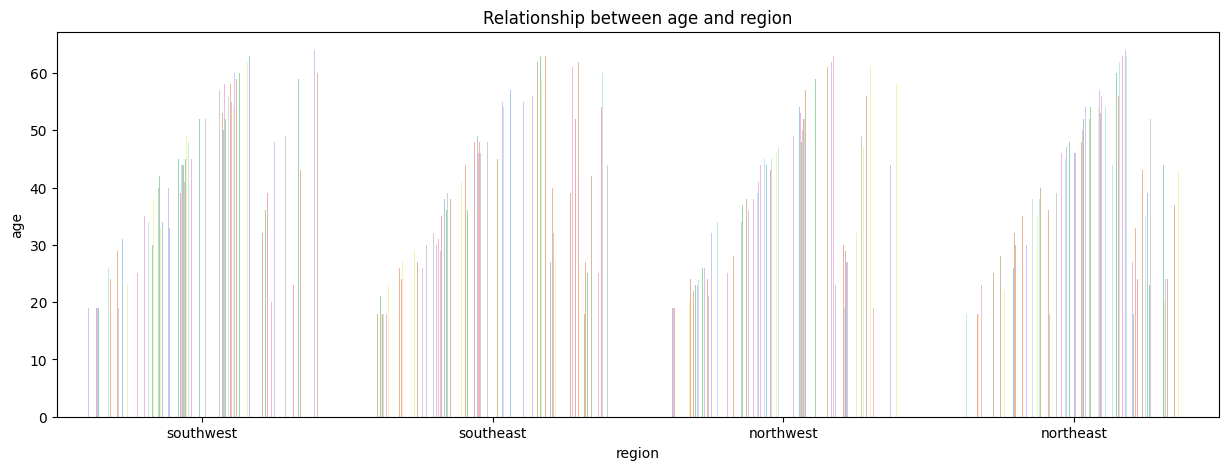

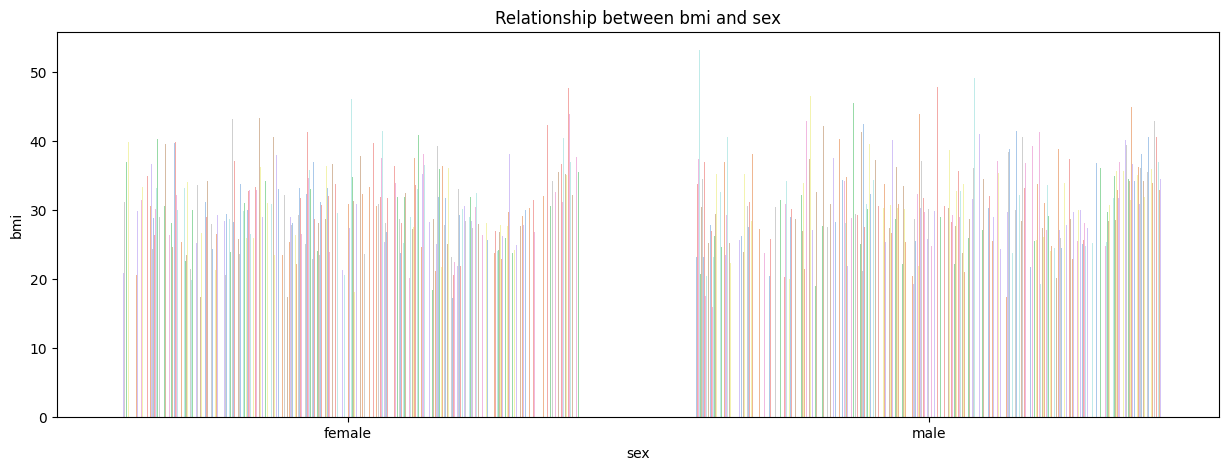

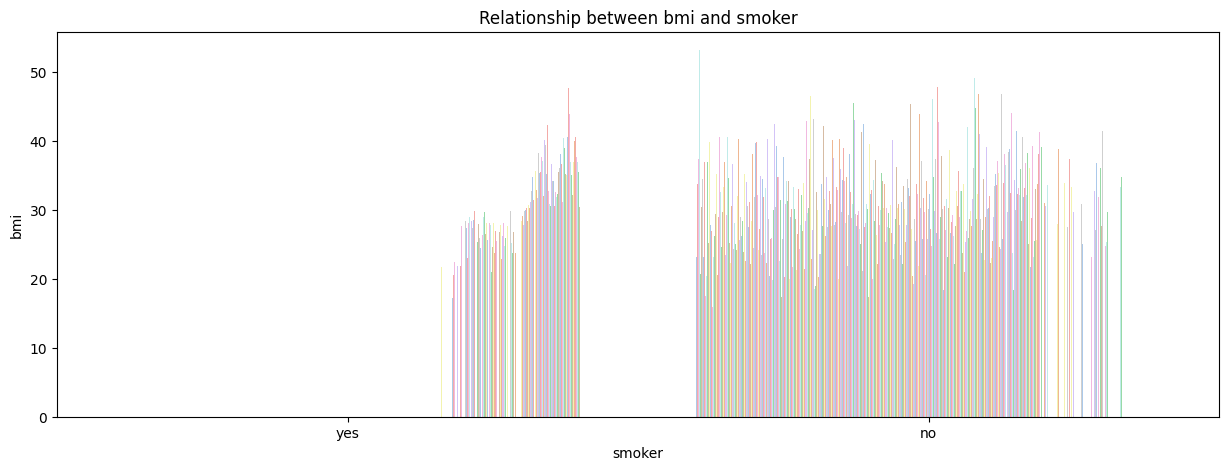

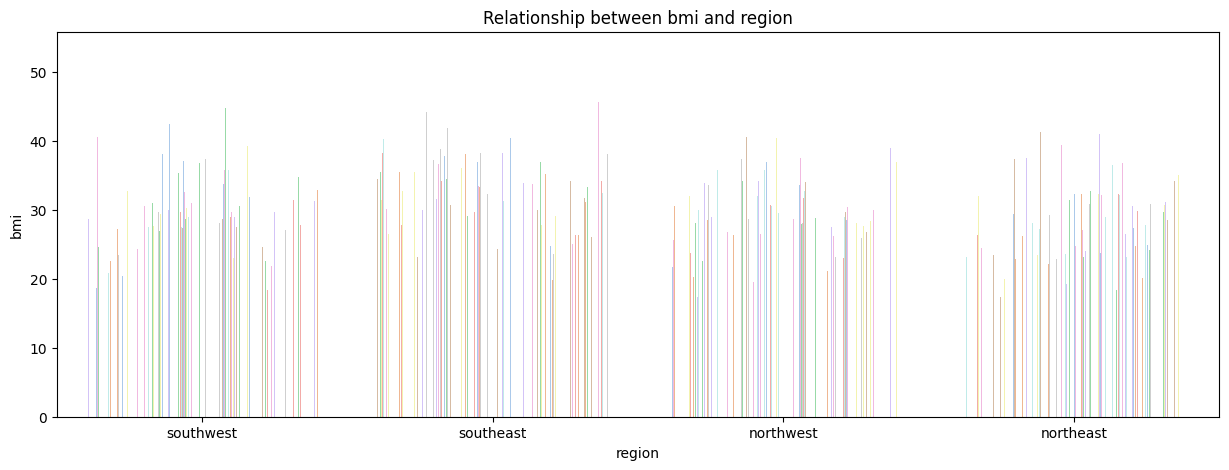

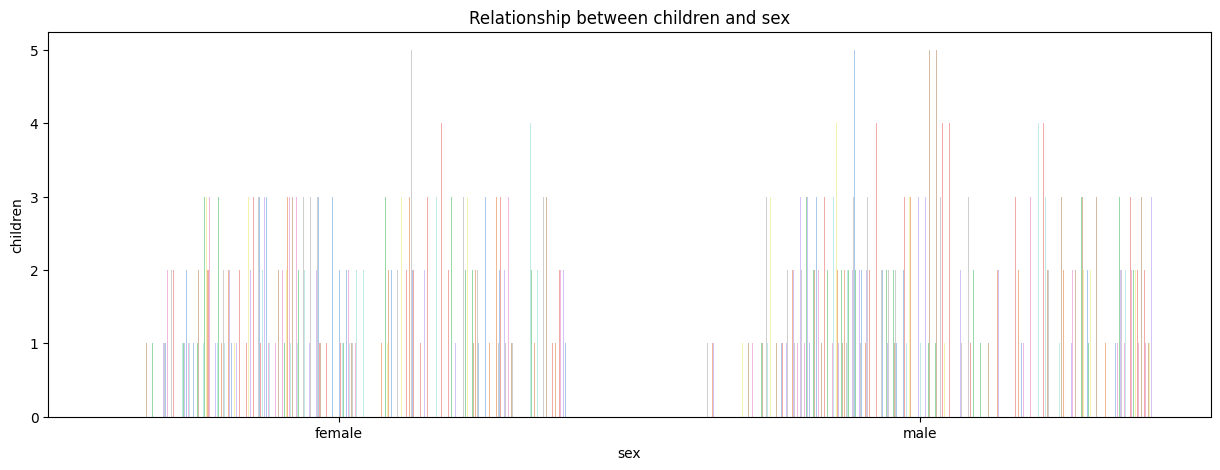

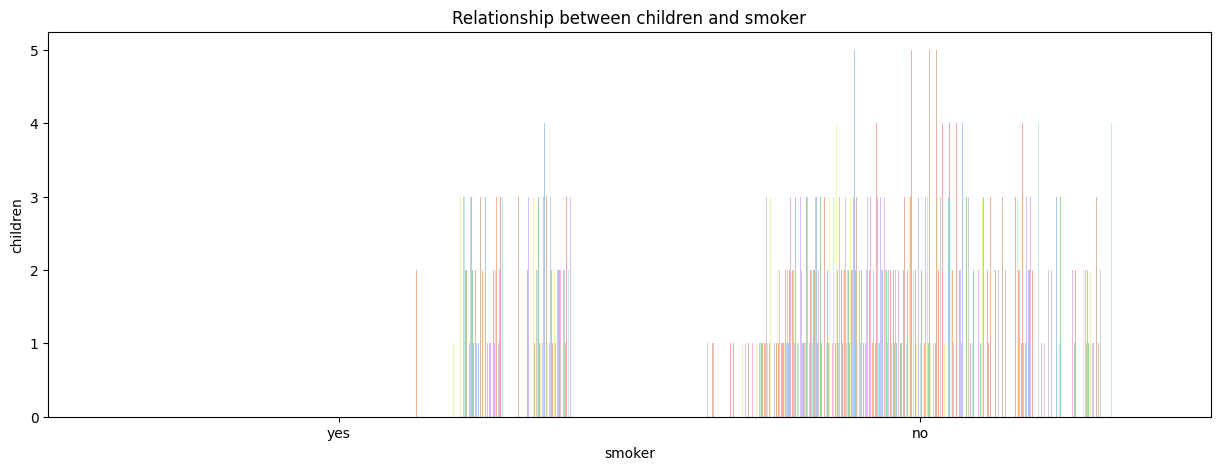

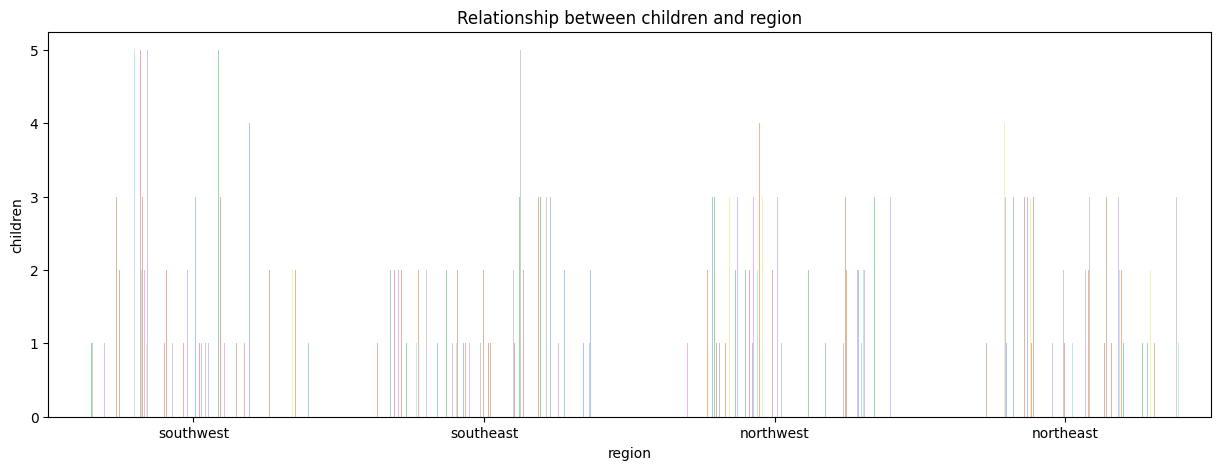

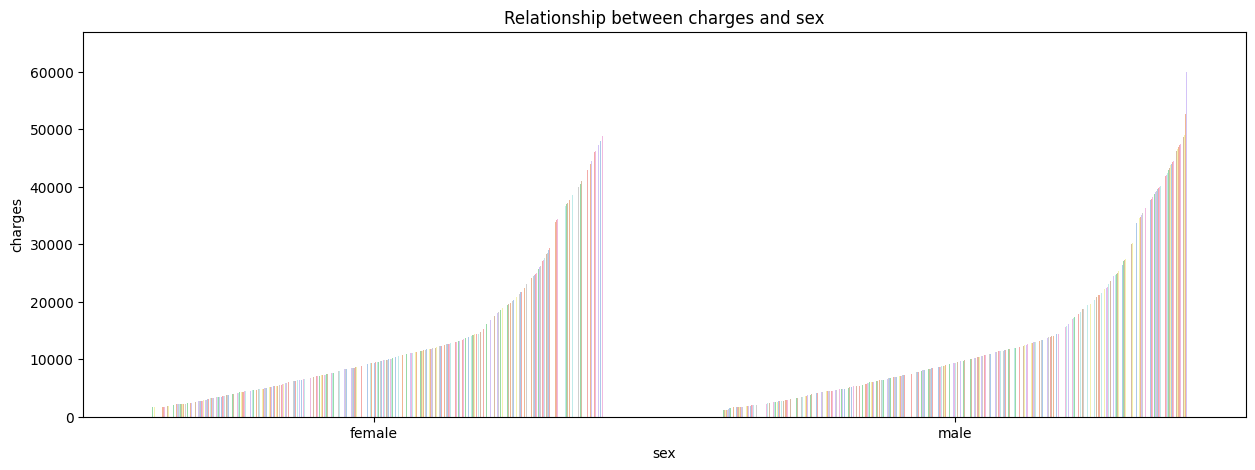

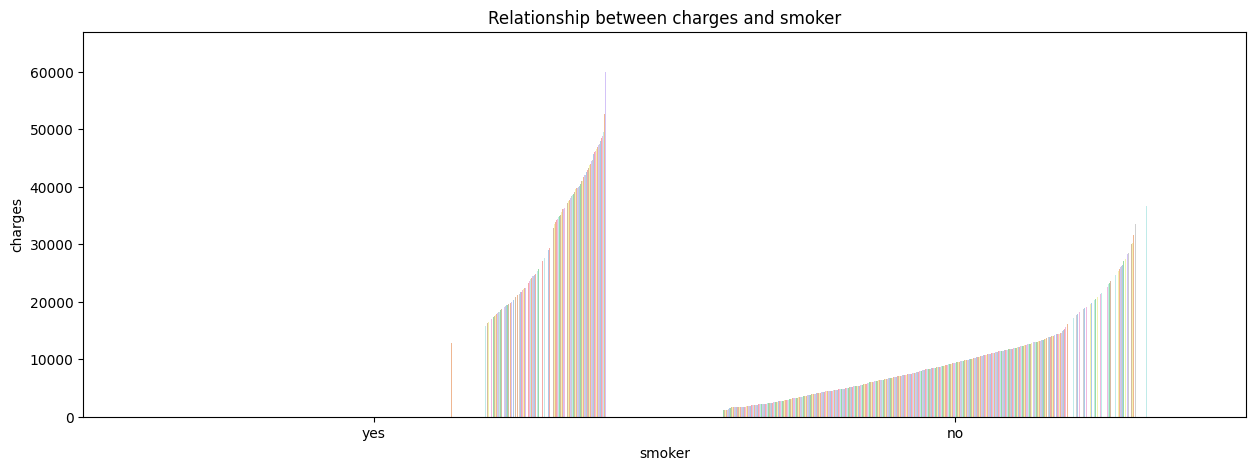

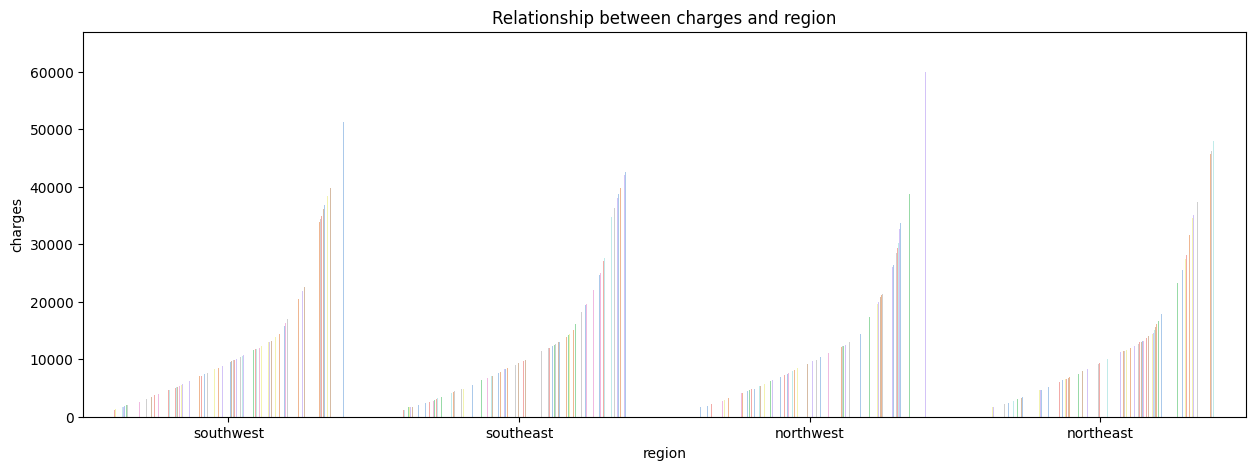

In [94]:
# visulizing the relationship between features
# gathering names of categorical and numerical features
cat_feats = [feat for feat in df.columns if df[feat].dtype == 'O']
num_feats = [feat for feat in df.columns if df[feat].dtype != 'O']
# plotting countplots for categorical features
for feat in cat_feats:
  sns.countplot(x = df[feat], palette = 'pastel', hue = df[feat], legend = False)
  plt.title(feat)
  plt.show()

# plotting histograms for numerical features
for feat in num_feats:
  sns.histplot(x = df[feat], kde = True)
  plt.title(feat)
  plt.show()

# plotting relationship plots
for n_feat in num_feats:
  for c_feat in cat_feats:
    sns.barplot(data = df, x = c_feat, y = n_feat, palette = 'pastel', hue = df[feat], legend = False)
    plt.title(f"Relationship between {n_feat} and {c_feat}")
    plt.show()

- Males are almost equaly to female
- Non-smokers are most then smokers
- We've 4 regions each with almost equal no. of values.
- Age is not-normally distributed nor skewed. But majority has an age of 20.
- bmi is normally distributed.
- Majority have no children then 1, 2, 3, 4 and 5. This column is actually categorical but is encoded.
- Charges (target feature) is skewed. Most of the people paid between 0 to 12000.
- Smokers paid more charges.
- Male and female paid almost equal charges.

<Axes: >

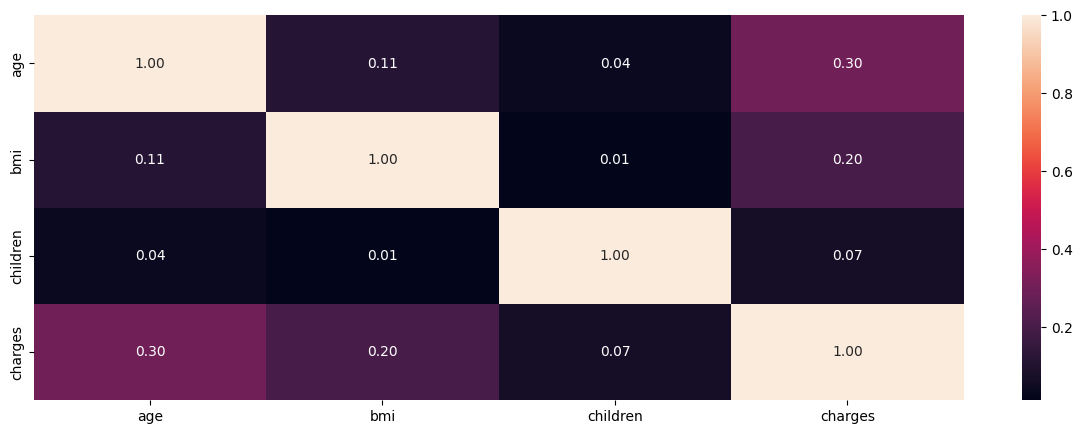

In [95]:
# seeing correlation between features
sns.heatmap(df.corr(numeric_only = True), annot = True, fmt = '.2f')

Features are very less correlated.

<Axes: >

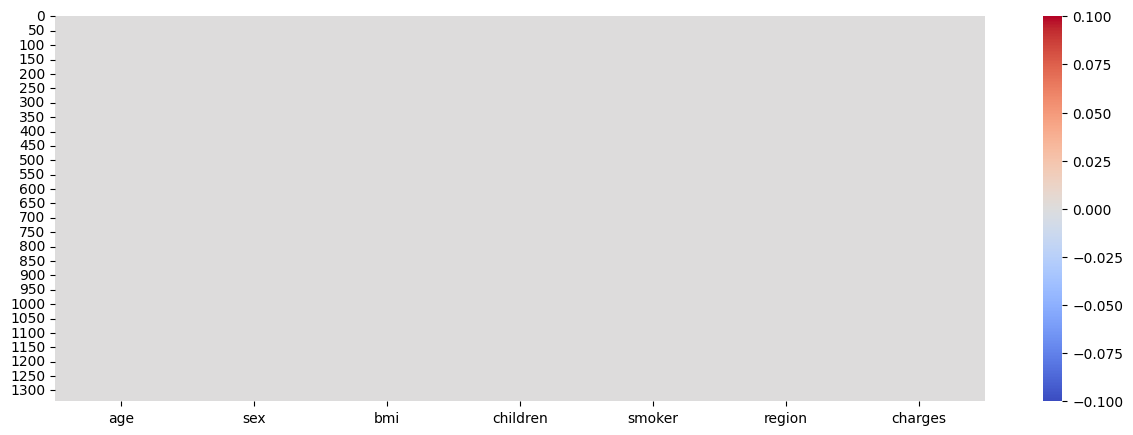

In [96]:
# Seeing missing values
sns.heatmap(df.isnull(), cmap = 'coolwarm')

Dataset has no missing values.

In [97]:
# checking the count of missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Feature Engineering

#### Seeing relationships

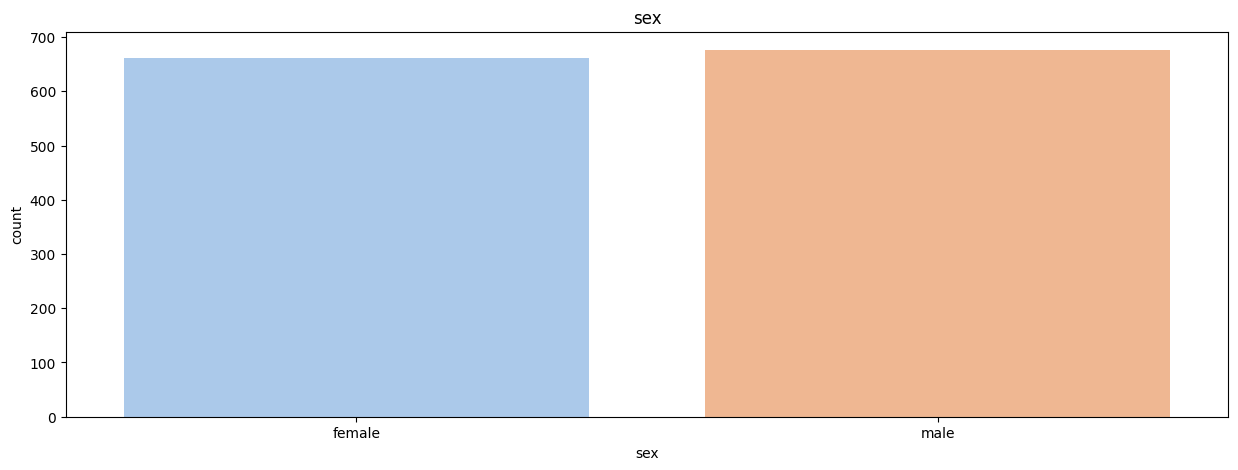

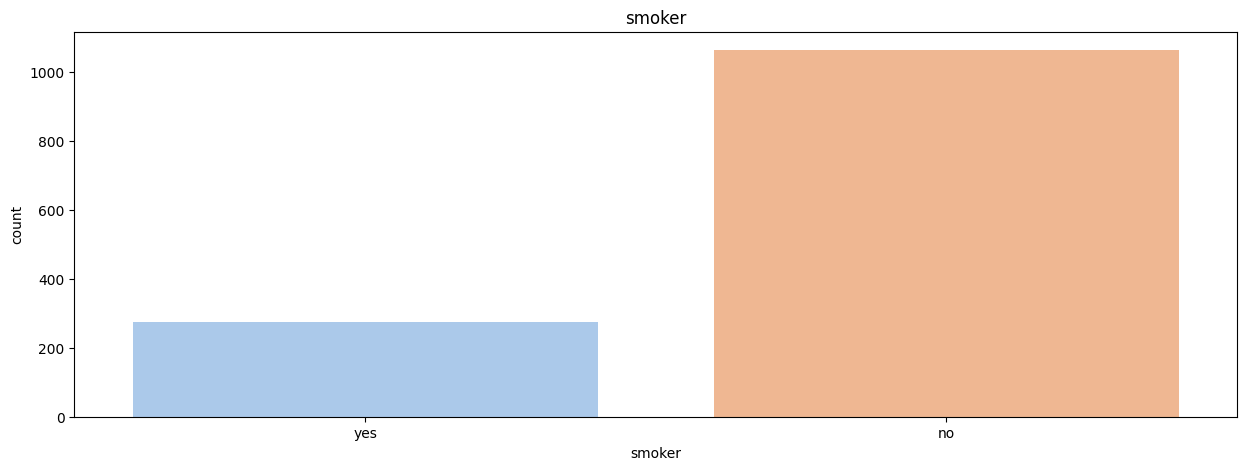

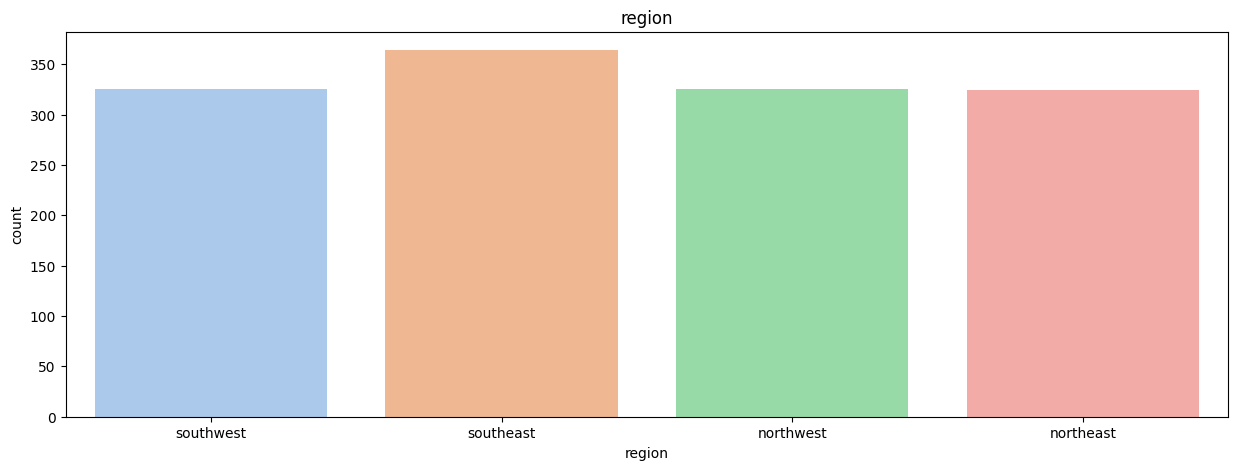

In [98]:
# seeing columns that are categorical (have object datatype i.e. are not encoded)
for feat in cat_feats:
  sns.countplot(x = df[feat], palette = 'pastel', hue = df[feat], legend = False)
  plt.title(feat)
  plt.show()

#### Sex Feature
Performing label encoding that will work like one hot encoding.

In [99]:
# creating new feature named male and assigning 1 to males and 0 to female
df['male'] = df['sex'].map({'male': 1, 'female': 0}).astype(int)
# dropping original sex column
df = df.drop('sex', axis = 1)
# seeing head
df.head(5)

,age,bmi,children,smoker,region,charges,male
0,19,27.900,0,yes,southwest,16884.92400,0
1,18,33.770,1,no,southeast,1725.55230,1
2,28,33.000,3,no,southeast,4449.46200,1
3,33,22.705,0,no,northwest,21984.47061,1
4,32,28.880,0,no,northwest,3866.85520,1


#### Smoker Feature
Doing same label encoding that will work like one hot encoding.

In [100]:
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0}).astype(int)
df.head(5)

,age,bmi,children,smoker,region,charges,male
0,19,27.900,0,1,southwest,16884.92400,0
1,18,33.770,1,0,southeast,1725.55230,1
2,28,33.000,3,0,southeast,4449.46200,1
3,33,22.705,0,0,northwest,21984.47061,1
4,32,28.880,0,0,northwest,3866.85520,1


#### Region Feature

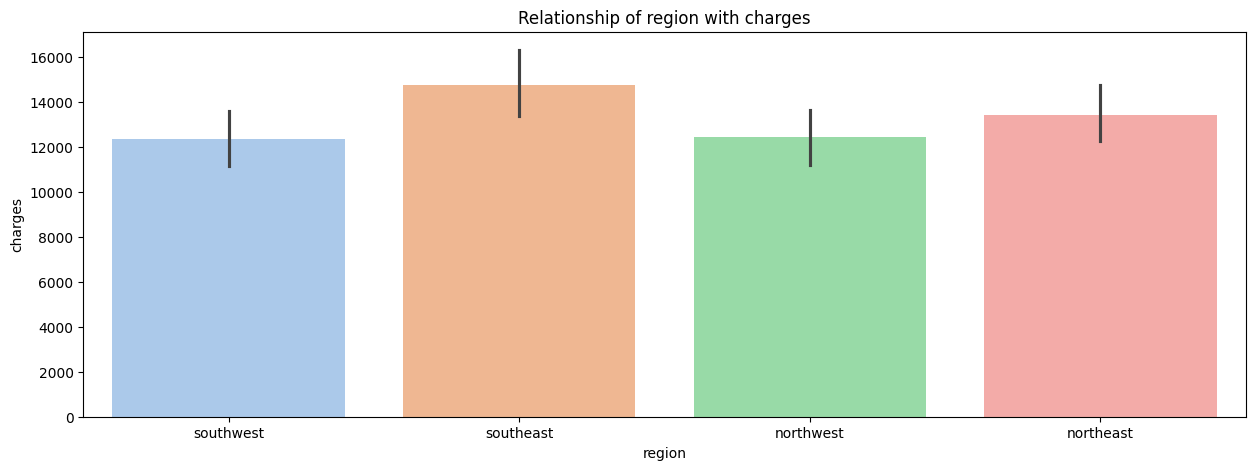

In [101]:
# using mean of each region category and visualizing the relationship
sns.barplot(df, x = 'region', y = 'charges', palette = 'pastel', hue = 'region', legend = False)
plt.title('Relationship of region with charges')
plt.show()

There is a relationship with the charges feature. But the data is not ordinal, so we will be using one hot encoding.

In [102]:
# creating dummies (0, 1 values) for the categories of the region feature and adding to the dataframe along with removing useless features
df = pd.get_dummies(df, columns = ['region'], drop_first = True, dtype = int)
df.head(5)

,age,bmi,children,smoker,charges,male,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,16884.92400,0,0,0,1
1,18,33.770,1,0,1725.55230,1,0,1,0
2,28,33.000,3,0,4449.46200,1,0,1,0
3,33,22.705,0,0,21984.47061,1,1,0,0
4,32,28.880,0,0,3866.85520,1,1,0,0


#### Handling Data Types

In [103]:
# seeing datatypes of the features
df.dtypes

age                   int64
bmi                 float64
children              int64
smoker                int64
charges             float64
male                  int64
region_northwest      int64
region_southeast      int64
region_southwest      int64
dtype: object

#### Train Test Split

In [104]:
# doing the split
x_train, x_test, y_train, y_test = train_test_split(df.drop('charges', axis = 1), df['charges'], test_size = 0.3, random_state = 20)
# printing shapes
print(f"Shape of x_train: {x_train.shape} \
      \nShape of x_test: {x_test.shape} \
      \nShape of y_train: {y_train.shape} \
      \nShape of y_test: {y_test.shape}")

Shape of x_train: (936, 8)       
Shape of x_test: (402, 8)       
Shape of y_train: (936,)       
Shape of y_test: (402,)


#### Feature Scaling

In [105]:
# initializing the standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
print(f"x_train: {x_train} \
    \n\nx_test: {x_test}")

x_train: [[ 0.00391262  0.78831415  0.73792225 ... -0.56748031 -0.61192266
   1.73205081]
 [-1.36044    -0.44074995 -0.9124845  ... -0.56748031 -0.61192266
  -0.57735027]
 [ 1.15284113  1.12184579 -0.9124845  ... -0.56748031 -0.61192266
   1.73205081]
 ...
 [-0.42693558 -0.19560419  2.388329   ... -0.56748031 -0.61192266
   1.73205081]
 [ 0.79380097  0.60487174  0.73792225 ... -0.56748031 -0.61192266
   1.73205081]
 [ 1.0810331  -0.91269722  1.56312562 ... -0.56748031 -0.61192266
   1.73205081]]     

x_test: [[ 1.22464917  0.52565798 -0.9124845  ...  1.76217569 -0.61192266
  -0.57735027]
 [ 0.79380097 -0.53580646 -0.9124845  ... -0.56748031 -0.61192266
  -0.57735027]
 [ 0.79380097  0.28801669  0.73792225 ... -0.56748031 -0.61192266
   1.73205081]
 ...
 [-1.07320787 -0.12389489 -0.9124845  ... -0.56748031 -0.61192266
  -0.57735027]
 [-0.78597574 -0.28232242 -0.08728113 ... -0.56748031 -0.61192266
  -0.57735027]
 [ 0.79380097  0.27217393 -0.9124845  ...  1.76217569 -0.61192266
  -0.5773

### Model Training and Evaluation

In [106]:
# creating model
dt = DecisionTreeRegressor()
# training the model
dt.fit(x_train, y_train)
# testing the model
y_pred = dt.predict(x_test)

In [107]:
# Calculating residual (difference between actual and predicted) and printing them
residuals = []
print('Residuals')
print('------------------------------\n')
for actual, pred in zip(y_test, y_pred):
  residue = actual - pred
  residuals.append(residue)

print(residuals)

Residuals
------------------------------

[-968.8869500000001, 16724.491260000003, 239.0510000000013, 934.9969999999994, 384.5707, 1.2509999999999764, 0.5282000000001972, -592.1183999999994, 2966.4994499999993, -818.6442999999999, 592.4332999999988, -166.72580000000016, 202.77305000000024, -1308.2195499999998, 3202.560999999998, 579.0246000000006, 2034.7033499999998, 338.43104999999923, 187.32799999999997, 765.7075999999997, -4662.79939, 210.8788999999997, -1.4525499999999738, -194.1312499999999, 607.0700000000006, 3.1692000000002736, -642.8725000000013, -11857.909459999999, -2114.0522999999957, 291.27759999999944, -1.9770000000007713, -209.09699999999975, 3723.7545500000015, -5701.568189999998, 7004.874520000001, 7.644999999999982, -925.1867999999995, -19137.88029, 1973.2877499999995, -1651.1380000000008, -9667.386250000001, -572.6722999999984, 413.6489999999999, -170.12300000000005, -2.9050999999999476, -301.1139999999996, 3.363800000000083, 582.2146500000003, -1595.0971500000014, -2

In [108]:
# evaluating the model using mean_squared_error
print(f"Root mean squared error: {np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")
print(f"Median squared error: {np.round(np.sqrt(np.median(sorted(np.square(residuals)))), 2)}")
print(f"R2 Score : {np.round(r2_score(y_test, y_pred) * 100, 2)}")

Root mean squared error: 5865.58
Median squared error: 534.06
R2 Score : 75.64


The model is not a very bad model as the R2 Score is not very bad. The rmeanse is high because some of the high values in the target feature are impacting the mean which is getting clarified by rmedianse. However, it can be improved by hyper-parameter tuning (will do soon).

## Random Forest Regression

In [109]:
from sklearn.ensemble import RandomForestRegressor

# creating model
rf = RandomForestRegressor()

# training the model
rf.fit(x_train, y_train)
# testing the model
y_pred = rf.predict(x_test)

# Calculating residual (difference between actual and predicted) and printing them
residuals = []
print('Residuals')
print('------------------------------\n')
for actual, pred in zip(y_test, y_pred):
  residue = actual - pred
  residuals.append(residue)

print(residuals)

# evaluating the model using mean_squared_error
print(f"Root mean squared error: {np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")
print(f"Median squared error: {np.round(np.sqrt(np.median(sorted(np.square(residuals)))), 2)}")
print(f"R2 Score : {np.round(r2_score(y_test, y_pred) * 100, 2)}")

Residuals
------------------------------

[-361.2095549999958, 16517.643073500003, -6967.205571600018, -2906.3027095999896, -460.3918486666664, -1926.6746399999977, -1941.1810178999945, -208.61660029999803, 2307.407517600008, -3359.2935841000035, -1781.9448236999906, -2256.339279000036, -3237.067131900001, -823.5047562, 402.8020980999863, -347.94967939999697, 885.1796800000084, 7414.873709199996, -164.9070504999977, 129.05357089999598, -1025.831958200004, -55.26463139999578, -434.26918410001235, -1408.9310589000013, -2342.9161712999976, -917.1370308999994, -120.8693789999852, -4714.096518400007, 617.4408919999696, -660.1803774000036, -0.2595355000048585, -1315.020364699999, 332.36584310001126, -1903.4997004000106, 13711.110634999979, -134.26390866666907, -5328.9110537999995, -11213.390672000005, 188.84637889997612, -1286.3594523999964, -4621.103145300005, -163.74112359999526, 39.6800614999986, -2378.425040599998, -1278.3895591000037, -5143.364894999998, -478.8511914000028, -3175.358912

## Linear Regression

In [110]:
from sklearn.linear_model import LinearRegression

# creating model
lr = LinearRegression()

# training the model
lr.fit(x_train, y_train)
# testing the model
y_pred = lr.predict(x_test)

# Calculating residual (difference between actual and predicted) and printing them
residuals = []
print('Residuals')
print('------------------------------\n')
for actual, pred in zip(y_test, y_pred):
  residue = actual - pred
  residuals.append(residue)

print(residuals)

# evaluating the model using mean_squared_error
print(f"Root mean squared error: {np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)}")
print(f"Median squared error: {np.round(np.sqrt(np.median(sorted(np.square(residuals)))), 2)}")
print(f"R2 Score : {np.round(r2_score(y_test, y_pred) * 100, 2)}")

Residuals
------------------------------

[-2177.295766255078, 15634.64200476451, -2239.425147478085, -2983.3106122963036, -2893.374261623944, -343.19575221445507, 1132.111541474928, -2604.294278387386, -8643.191243981848, -2548.4142386350723, -588.868255204743, 5363.13527509855, -266.6482622558042, -3152.647811615385, -11254.182562672471, -644.7984189746021, -9955.187054839269, 6920.072468614948, 136.21916411995744, 594.7612478932188, 8845.748634473282, 1431.3207896130134, 738.518651988652, -758.5598686321653, -6097.882938300858, -1991.6186968536176, -9997.161871762768, -1512.581443242576, 7599.859072956082, -3773.7442378723536, -1615.8758868894638, 378.2772806366356, -7803.149640716641, 7913.154158544254, 18887.78600274293, -4445.2516335276705, 191.7973896222693, 1467.2365091725437, -10334.869684236804, -11355.615971938269, -163.928932237548, -2797.347937486622, 126.28990942352311, 1942.3424292611194, -781.6945325523411, -1058.0042464822172, -5221.101229061116, -1363.7829501306878, 7

Random Forest gave the best performance, then Logistic Regression and then Our Decision Tree.